# Introduction, Description
This notebook is dedicated to the development of a pipeline that perform a quality assessment of an eeg signal.
The different metrics will be calculated:
- Average Root Mean Square (RMS) of a sliding window
- Maximum Gradient of a sliding window
- Zero Crossing Rate of a sliding window
- Complexity of the signal (Hjorth's parameters) of a sliding window
- Kurtosis of a sliding window
- Skewness of a sliding window
- Variance of a sliding window
- Range of a sliding window
- Interquartile range of a sliding window
- Signal to Noise Ratio (SNR)
    - Time domain: 
        - ECG based epochs (signal = average across epochs, noise = std across epochs) need to be lowered
        - TR based epochs (signal = average across epochs, noise = std across epochs) need to be lowered
        - EEG based epochs (signal = average across epochs, noise = std across epochs) need to be increased
    - Frequency domain:
        - Gradient artifacts (signal = peak frequency of the cross-correlation of the non-cleaned signal, noise = average of the n surrounding bins around the peak)
        - Base frequency of the task (signal = amplitude at the base freqeuency, noise = average of the n surrounding bins around the peak)

In [1]:
import mne
import numpy as np
import matplotlib.pyplot as plt
from EEG_quality_assessment import frequency_analysis as spectrums_package
raw = mne.io.read_raw_fif(
    '/Users/samuel/01_projects/EEG_quality_assessment/tests/sub-04_ses-01_task-rest_run-01_desc-HomeMadePipeline_eeg.fif', 
    preload=True)
spectrum_object = spectrums_package.Spectrum()
fft = spectrum_object.calculate_fft(raw)
amplitude = spectrum_object.copy().calculate_amplitude()
amplitude._set_frequency_of_interest(18)
zscore = amplitude.copy().calculate_zscore()
snr = amplitude.copy().calculate_snr()

Opening raw data file /Users/samuel/01_projects/EEG_quality_assessment/tests/sub-04_ses-01_task-rest_run-01_desc-HomeMadePipeline_eeg.fif...
    Read a total of 7 projection items:
        eeg-Raw-0.000-693.120-PCA-01 (1 x 61) active
        eeg-Raw-0.000-693.120-PCA-02 (1 x 61) active
        eeg-Raw-0.000-693.120-PCA-03 (1 x 61) active
        ECG-eeg--0.200-0.400-PCA-01 (1 x 61) active
        ECG-eeg--0.200-0.400-PCA-02 (1 x 61) active
        EOG-eeg--0.200-0.200-PCA-01 (1 x 61) active
        EOG-eeg--0.200-0.200-PCA-02 (1 x 61) active
    Range : 0 ... 173279 =      0.000 ...   693.116 secs
Ready.
Reading 0 ... 173279  =      0.000 ...   693.116 secs...


AxisError: destination: axis 1 is out of bounds for array of dimension 1

In [1]:
a = ['a','b','c']
'b' in a

True

# Plotting prototype
This is a prototype of a plotting method that will be integrated to the Spectrum class.

In [1]:
%matplotlib qt
channel = 1
f_min = 0
f_max = 40
obj = snr
channels = ['ECG']
def plot_tagging(obj,
                 f_min = 0,
                 f_max = 40,
                 range_to_find_peak = (17,19),
                 ):
        
        index_f_min = obj._get_frequency_index(f_min) + int( obj.sampling_rate)
        index_f_max = obj._get_frequency_index(f_max)
        max_spectrum = np.max(obj.spectrum[:,index_f_min:index_f_max])
        obj.average()
        plt.plot(obj.frequencies[index_f_min:index_f_max], 
                obj.spectrum[:,index_f_min:index_f_max].T,
                color = 'black',
                alpha = 0.5,
                )
        y_min = np.min(obj.spectrum[:,index_f_min:index_f_max])
        y_max = 6*max_spectrum/5
        plt.ylim(y_min, y_max)
        plt.xlim(f_min, f_max)
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Amplitude (V^2/Hz)')
        if range_to_find_peak:
                obj.get_peak_magnitude(range_to_find_peak)
                freq_window = fft.frequencies[
                        obj.index_window[0]:obj.index_window[1]
                        ]
                plt.fill_between(freq_window,
                                y1 = 6*max_spectrum, 
                                y2 = y_min,
                                color='orange', 
                                alpha=0.3, 
                                label="Search Window",
                                )
                plt.axhline(obj.peak_magnitude, 
                                color='r', 
                                linewidth=1, 
                                alpha=0.5, 
                                label="Peak Magnitude",
                                )
                plt.axvline(obj.peak_frequency_Hz, 
                                color='g', 
                                linewidth=1, 
                                alpha =  0.5, 
                                label="Peak Frequency",
                                )
                txt = " ".join([str(np.round(obj.peak_magnitude[0],3)),
                                obj.info['units'],
                                str(np.round(obj.peak_frequency_Hz[0],2)),
                                "Hz"]
                )
                plt.text(x = obj.peak_frequency_Hz[0]+f_max/100, 
                         y = obj.peak_magnitude[0]+y_max/100,
                         s = txt,
                        fontsize=8)
        plt.legend()

NameError: name 'snr' is not defined

## Testing

In [27]:
a = zscore.copy().pick_channels(['Fp1']).average()
plot_tagging(a)

# Naive implementation
With windowing method using for loops and lists.

In [2]:
import mne
import numpy as np
import matplotlib.pyplot as plt
from EEG_quality_assessment import frequency_analysis, time_analysis 
raw = mne.io.read_raw_fif(
    '/Users/samuel/01_projects/EEG_quality_assessment/tests/sub-04_ses-01_task-rest_run-01_desc-HomeMadePipeline_eeg.fif', 
    preload=True,
)
spectrum_object = frequency_analysis.Spectrum()
fft = spectrum_object.calculate_fft(raw)
amplitude = spectrum_object.copy().calculate_amplitude()
amplitude._set_frequency_of_interest(18)
zscore = amplitude.copy().calculate_zscore()
snr = amplitude.copy().calculate_snr()

time_window = 1
overlap = 0.5
data = raw.get_data()
metrics = {
    channel_name:
    {
    'average_rms': list(),
    'max_gradient': list(),
    'zero_crossing_rate': list(),
    'hjorth_mobility': list(),
    'hjorth_complexity': list(),
    'kurtosis': list(),
    'skewness': list(),
    'variance': list(),
    'signal_range': list(),
    'signal_IQR': list(),
    }
    for channel_name in raw.info['ch_names']
    
}
starts = np.arange(0, data.shape[1], int((time_window*raw.info['sfreq']))*overlap)
ends = starts + int((time_window*raw.info['sfreq']))

for channel_nb in range(data.shape[0]):
    for start, end in zip(starts, ends):
        if end > data.shape[1]:
            break
        segment = data[channel_nb, int(start):int(end)]
        ch_name = raw.info['ch_names'][channel_nb]
        for metric in metrics[ch_name]:
            metrics[ch_name][metric].append(getattr(time_analysis, metric)(segment))
        
    metrics[ch_name]['amplitudes'] = amplitude.spectrum[channel_nb, :]
    metrics[ch_name]['snr'] = snr.spectrum[channel_nb, :]
    metrics[ch_name]['zscore'] = zscore.spectrum[channel_nb, :]


Opening raw data file /Users/samuel/01_projects/EEG_quality_assessment/tests/sub-04_ses-01_task-rest_run-01_desc-HomeMadePipeline_eeg.fif...
    Read a total of 7 projection items:
        eeg-Raw-0.000-693.120-PCA-01 (1 x 61) active
        eeg-Raw-0.000-693.120-PCA-02 (1 x 61) active
        eeg-Raw-0.000-693.120-PCA-03 (1 x 61) active
        ECG-eeg--0.200-0.400-PCA-01 (1 x 61) active
        ECG-eeg--0.200-0.400-PCA-02 (1 x 61) active
        EOG-eeg--0.200-0.200-PCA-01 (1 x 61) active
        EOG-eeg--0.200-0.200-PCA-02 (1 x 61) active
    Range : 0 ... 173279 =      0.000 ...   693.116 secs
Ready.
Reading 0 ... 173279  =      0.000 ...   693.116 secs...


AxisError: destination: axis 1 is out of bounds for array of dimension 1

# Optimized implementation
With windowing method using numpy arrays and vectorized operations.

## Sanity check of the sliding window approach

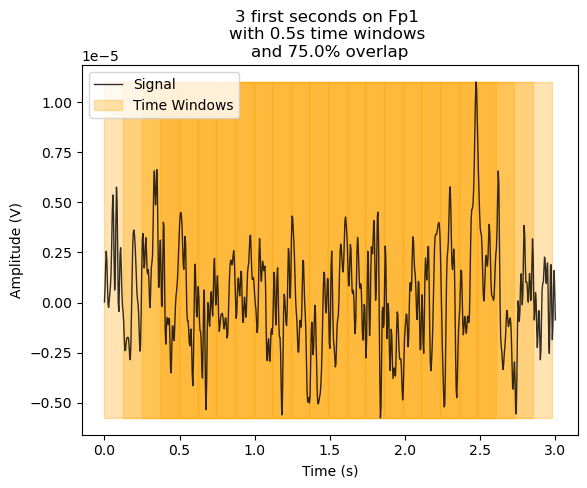

In [31]:
from numpy.lib.stride_tricks import sliding_window_view
channel = 'Fp1'
time = 3
chan_nb = raw.info['ch_names'].index(channel)
time_window = 0.5
overlap = 0.75
copy_raw = raw.copy().crop(0,time)
data = copy_raw.get_data()
time_samples = np.arange(0, data.shape[1])
window_samples = int((time_window*raw.info['sfreq']))
step = int(window_samples - window_samples*overlap)
window_view = sliding_window_view(time_samples, 
                                  window_samples)[::step]
plt.plot(copy_raw.times, 
         data[chan_nb,:], 
         color = 'black',
         linewidth = 1,
         alpha = 0.8,
         label = 'Signal')

for jump in range(window_view.shape[0]-1):
    plt.fill_between(window_view[jump,:]/raw.info['sfreq'], 
                     y1 = np.min(data[chan_nb,:]), 
                     y2 = np.max(data[chan_nb,:]), 
                     alpha = 0.3, 
                     color = 'orange',
                     )

plt.fill_between(window_view[-1,:]/raw.info['sfreq'],
                 y1 = np.min(data[chan_nb,:]), 
                 y2 = np.max(data[chan_nb,:]), 
                 alpha = 0.3, 
                 color = 'orange',
                 label = 'Time Windows'
                    )

plt.xlabel('Time (s)')
plt.ylabel('Amplitude (V)')
plt.title(f"{time} first seconds on {channel} \nwith {time_window}s time windows \nand {overlap*100}% overlap")
plt.legend(loc = 'upper left')

In [4]:
from numpy.lib.stride_tricks import sliding_window_view

import mne
import numpy as np
import matplotlib.pyplot as plt
from EEG_quality_assessment import frequency_analysis, time_analysis 
raw = mne.io.read_raw_fif(
    '/Users/samuel/01_projects/EEG_quality_assessment/tests/sub-04_ses-01_task-rest_run-01_desc-HomeMadePipeline_eeg.fif', 
    preload=True,
)
spectrum_object = frequency_analysis.Spectrum()
fft = spectrum_object.calculate_fft(raw)
amplitude = spectrum_object.copy().calculate_amplitude()
amplitude._set_frequency_of_interest(18)
zscore = amplitude.copy().calculate_zscore()
snr = amplitude.copy().calculate_snr()

time_window = 1
overlap = 0.5
data = raw.get_data()
samples = np.arange(0, data.shape[1])
window_nb_samples = int((time_window*raw.info['sfreq']))
step = int(window_nb_samples -window_nb_samples *overlap)
window_view = sliding_window_view(samples , 
                                  window_nb_samples )[::step]

starts = np.arange(0, data.shape[1], int((time_window*raw.info['sfreq']))*overlap)
ends = starts + int((time_window*raw.info['sfreq']))
metrics_name = ['average_rms', 
                'max_gradient',
                'zero_crossing_rate',
                'hjorth_mobility',
                'hjorth_complexity',
                'kurtosis',
                'skewness',
                'variance',
                'signal_range',
                'signal_IQR']

metrics = {name: np.empty(shape = (data.shape[0], window_view.shape[0])) 
           for name in metrics_name}

for window_index in range(window_view.shape[0]):
    windowed_signal = data[:, window_view[window_index,:]]
    for metric in metrics_name:
        metrics[metric][:,window_index] = getattr(
            time_analysis, metric)(windowed_signal)

metrics['amplitudes'] = amplitude.spectrum
metrics['snr'] = snr.spectrum
metrics['zscore'] = zscore.spectrum


Opening raw data file /Users/samuel/01_projects/EEG_quality_assessment/tests/sub-04_ses-01_task-rest_run-01_desc-HomeMadePipeline_eeg.fif...
    Read a total of 7 projection items:
        eeg-Raw-0.000-693.120-PCA-01 (1 x 61) active
        eeg-Raw-0.000-693.120-PCA-02 (1 x 61) active
        eeg-Raw-0.000-693.120-PCA-03 (1 x 61) active
        ECG-eeg--0.200-0.400-PCA-01 (1 x 61) active
        ECG-eeg--0.200-0.400-PCA-02 (1 x 61) active
        EOG-eeg--0.200-0.200-PCA-01 (1 x 61) active
        EOG-eeg--0.200-0.200-PCA-02 (1 x 61) active
    Range : 0 ... 173279 =      0.000 ...   693.116 secs
Ready.
Reading 0 ... 173279  =      0.000 ...   693.116 secs...


AxisError: destination: axis 1 is out of bounds for array of dimension 1

# Full vectorization of the sliding window approach
Trying to get rid of for loops and use only numpy vectorized operations.

## Sanity check of the full vectorization approach
First the time samples windowing is checked.

In [5]:
from numpy.lib.stride_tricks import sliding_window_view
channel = 'Fp1'
chan_nb = raw.info['ch_names'].index(channel)
time_window = 1
overlap = 0.5
copy_raw = raw.copy().crop(0,3)
data = copy_raw.get_data()
time_samples = np.arange(0, data.shape[1])
window_samples = int((time_window*raw.info['sfreq']))
step = int(window_samples - window_samples*overlap)
window_view = sliding_window_view(time_samples, 
                                  window_samples)[::step]
plt.plot(data[chan_nb,:])

for jump in range(window_view.shape[0]):
    plt.fill_between(window_view[jump,:], 
                     y1 = np.min(data[chan_nb,:]), 
                     y2 = np.max(data[chan_nb,:]), 
                     alpha = 0.3, 
                     color = 'orange')

Now, check the values of one calculated metric using the time indexing.

In [6]:
from numpy.lib.stride_tricks import sliding_window_view
from EEG_quality_assessment import time_analysis
channel = 'Fp1'
chan_nb = raw.info['ch_names'].index(channel)
time_window = 0.5
overlap = 0
copy_raw = raw.copy().crop(0,3)
data = copy_raw.get_data()
time_samples = np.arange(0, data.shape[1])
window_samples = int((time_window*raw.info['sfreq']))
step = int(window_samples - window_samples*overlap)
window_view = sliding_window_view(time_samples, 
                                  window_samples)[::step]
plt.plot(data[chan_nb,:])

for jump in range(window_view.shape[0]):
    plt.fill_between(window_view[jump,:], 
                     y1 = np.min(data[chan_nb,:]), 
                     y2 = np.max(data[chan_nb,:]), 
                     alpha = 0.3, 
                     color = 'orange')
    plt.scatter(window_view[jump,window_view.shape[1]//2],
                time_analysis.average_rms(data[:,window_view[jump,:]],
                                          axis = 1)[chan_nb],
                color = 'r')

Check the values of one calculated metric using the vectorization.

In [9]:

from numpy.lib.stride_tricks import sliding_window_view
from EEG_quality_assessment import time_analysis
import mne
import numpy as np
raw = mne.io.read_raw_fif(
    '/Users/samuel/01_projects/EEG_quality_assessment/tests/sub-04_ses-01_task-rest_run-01_desc-HomeMadePipeline_eeg.fif', 
    preload=True,
)
channel = 'Fp1'
chan_nb = raw.info['ch_names'].index(channel)
time_window = 0.5
overlap = 0 
copy_raw = raw.copy().crop(0,3)
data = copy_raw.get_data()
time_samples = np.arange(0, data.shape[1])
window_samples = int((time_window*raw.info['sfreq']))
step = int(window_samples - window_samples*overlap)
window_view2 = sliding_window_view(data, 
                                  window_shape = window_samples,
                                  axis = 1)[:,::step,:]
#plt.plot(data[chan_nb,:])
calculation = time_analysis.average_rms(window_view2, axis= 2)


Opening raw data file /Users/samuel/01_projects/EEG_quality_assessment/tests/sub-04_ses-01_task-rest_run-01_desc-HomeMadePipeline_eeg.fif...
    Read a total of 7 projection items:
        eeg-Raw-0.000-693.120-PCA-01 (1 x 61) active
        eeg-Raw-0.000-693.120-PCA-02 (1 x 61) active
        eeg-Raw-0.000-693.120-PCA-03 (1 x 61) active
        ECG-eeg--0.200-0.400-PCA-01 (1 x 61) active
        ECG-eeg--0.200-0.400-PCA-02 (1 x 61) active
        EOG-eeg--0.200-0.200-PCA-01 (1 x 61) active
        EOG-eeg--0.200-0.200-PCA-02 (1 x 61) active
    Range : 0 ... 173279 =      0.000 ...   693.116 secs
Ready.
Reading 0 ... 173279  =      0.000 ...   693.116 secs...


In [9]:
window_view2.shape

(64, 6, 125)

In [10]:
np.moveaxis(window_view2, 0, 1).shape

(6, 64, 125)

In [10]:
from matplotlib import pyplot as plt
plt.plot(data[chan_nb,:])
for jump in range(window_view2.shape[1]):
    plt.fill_between(window_view[jump,:], 
                     y1 = np.min(data[chan_nb,:]), 
                     y2 = np.max(data[chan_nb,:]), 
                     alpha = 0.3, 
                     color = 'orange')
    plt.scatter(window_view[jump,window_view.shape[1]//2],
                time_analysis.average_rms(
                    data[:,window_view[jump,:]],
                    axis = 1,
                    )[chan_nb],
                marker = 'x',
                s = 100,
                color = 'r')
plt.scatter(window_view[:,window_view.shape[1]//2],calculation[chan_nb,:], 
            color = 'purple',
            marker='+',
            s = 100,
            alpha = 0.8)

In [8]:
from matplotlib import pyplot as plt
for jump in range(window_view2.shape[1]):
    plt.fill_between(window_view[jump,:], 
                     y1 = np.min(data[chan_nb,:]), 
                     y2 = np.max(data[chan_nb,:]), 
                     alpha = 0.3, 
                     color = 'orange')
    plt.scatter(window_view[jump,window_view.shape[1]//2],
                time_analysis.average_rms(
                    data[:,window_view[jump,:]],
                    axis = 1,
                    )[chan_nb],
                marker = 'x',
                s = 100,
                color = 'r')
plt.scatter(window_view[:,window_view.shape[1]//2],calculation[chan_nb,:], 
            color = 'purple',
            marker='+',
            s = 100,
            alpha = 0.8)

NameError: name 'window_view2' is not defined

In [34]:
from EEG_quality_assessment import signal_metrics
import mne
raw = mne.io.read_raw_edf(
    '/Users/samuel/01_projects/EEG_quality_assessment/tests/sub-06_ses-01_task-rest_run-01_eeg.edf', 
    preload=True,
    encoding='latin1')

ECG_epochs = mne.preprocessing.create_ecg_epochs(raw)
metrics = signal_metrics.SignalMetrics(ECG_epochs)
metrics.calculate_metrics()

Extracting EDF parameters from /Users/samuel/01_projects/EEG_quality_assessment/tests/sub-06_ses-01_task-rest_run-01_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 156499  =      0.000 ...   625.996 secs...


/var/folders/l3/myr9vj8933q4vwhkbvxcx6gc0000gn/T/ipykernel_21228/4222021811.py:3: RuntimeWarning: Number of records from the header does not match the file size (perhaps the recording was not stopped before exiting). Inferring from the file size.
  raw = mne.io.read_raw_edf(


ValueError: Unable to generate artificial ECG channel

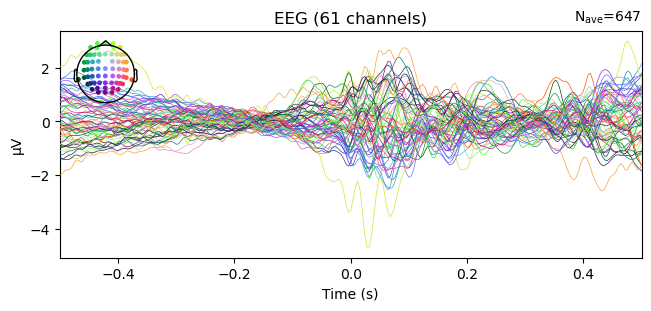

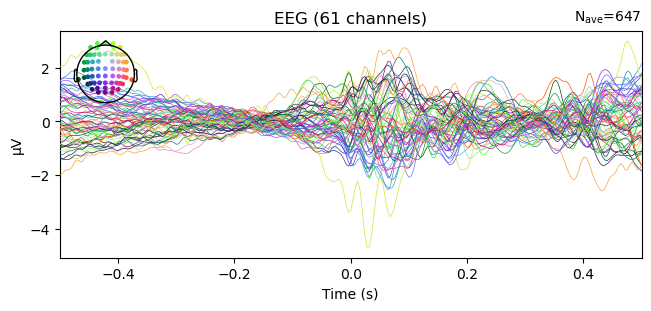

In [33]:
ECG_epochs.copy().average().plot()

In [2]:
import numpy as np
a = np.array([[1,2,3,4,5,6,7,8,9],
             [9,8,7,6,5,4,3,2,1]])
a[[0,1],[0:4]]


SyntaxError: invalid syntax (3866411505.py, line 4)

In [16]:
a[np.arange(stop = 2), [3,4]]

array([4, 5])

In [5]:
import numpy as np

A = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
B = np.array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19])

result = np.linspace(A, B, num=10, axis=1)


In [6]:
result

array([[ 0.        ,  1.11111111,  2.22222222,  3.33333333,  4.44444444,
         5.55555556,  6.66666667,  7.77777778,  8.88888889, 10.        ],
       [ 1.        ,  2.11111111,  3.22222222,  4.33333333,  5.44444444,
         6.55555556,  7.66666667,  8.77777778,  9.88888889, 11.        ],
       [ 2.        ,  3.11111111,  4.22222222,  5.33333333,  6.44444444,
         7.55555556,  8.66666667,  9.77777778, 10.88888889, 12.        ],
       [ 3.        ,  4.11111111,  5.22222222,  6.33333333,  7.44444444,
         8.55555556,  9.66666667, 10.77777778, 11.88888889, 13.        ],
       [ 4.        ,  5.11111111,  6.22222222,  7.33333333,  8.44444444,
         9.55555556, 10.66666667, 11.77777778, 12.88888889, 14.        ],
       [ 5.        ,  6.11111111,  7.22222222,  8.33333333,  9.44444444,
        10.55555556, 11.66666667, 12.77777778, 13.88888889, 15.        ],
       [ 6.        ,  7.11111111,  8.22222222,  9.33333333, 10.44444444,
        11.55555556, 12.66666667, 13.77777778

In [5]:
b.reshape(4,1)

NameError: name 'b' is not defined

In [14]:
b.shape

(4,)

In [ ]:
for jump in range(window_view.shape[0]):
    plt.fill_between(window_view[jump,:], 
                     y1 = np.min(data[chan_nb,:]), 
                     y2 = np.max(data[chan_nb,:]), 
                     alpha = 0.3, 
                     color = 'orange')
    plt.scatter(window_view[jump,window_view.shape[1]//2],
                time_analysis.average_rms(data[:,window_view[jump,:]])[chan_nb],
                color = 'r')

In [2]:
metrics['variance'].shape

(64, 1385)

In [130]:
window_view.shape

(5, 250)

In [90]:
raw.info.keys()

dict_keys(['file_id', 'events', 'hpi_results', 'hpi_meas', 'subject_info', 'device_info', 'helium_info', 'hpi_subsystem', 'proc_history', 'meas_id', 'experimenter', 'description', 'proj_id', 'proj_name', 'meas_date', 'utc_offset', 'sfreq', 'highpass', 'lowpass', 'line_freq', 'gantry_angle', 'chs', 'dev_head_t', 'ctf_head_t', 'dev_ctf_t', 'dig', 'bads', 'ch_names', 'nchan', 'projs', 'comps', 'acq_pars', 'acq_stim', 'custom_ref_applied', 'xplotter_layout', 'kit_system_id'])

- sfreq
- highpass
- lowpass
- chs
- line_freq
- bads
- ch_names

In [75]:
raw.set_channel_types({'ECG':'ecg'})

Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,64 points
Good channels,"61 EEG, 1 ECG, 2 EOG"
Bad channels,None
EOG channels,"EOGL, EOGU"
ECG channels,ECG
Sampling frequency,250.00 Hz
Highpass,1.00 Hz
Lowpass,50.00 Hz


Using channel ECG to identify heart beats.
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 8.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 7.75 Hz)
- Upper passband edge: 16.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 16.25 Hz)
- Filter length: 2500 samples (10.000 s)

Number of ECG events detected : 650 (average pulse 58 / min.)
Not setting metadata
650 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 7)
7 projection items activated
Using data from preloaded Raw for 650 events and 251 original time points ...
3 bad epochs dropped


In [86]:
raw.ch_names.index('ECG')

31

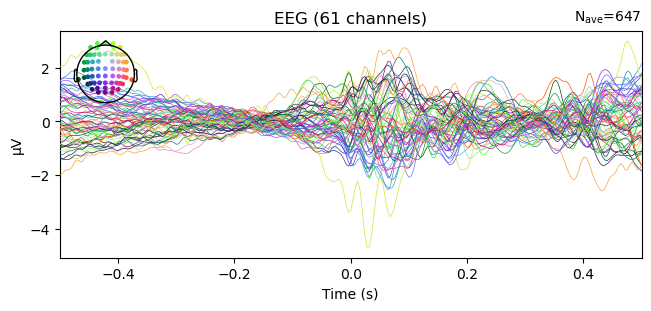

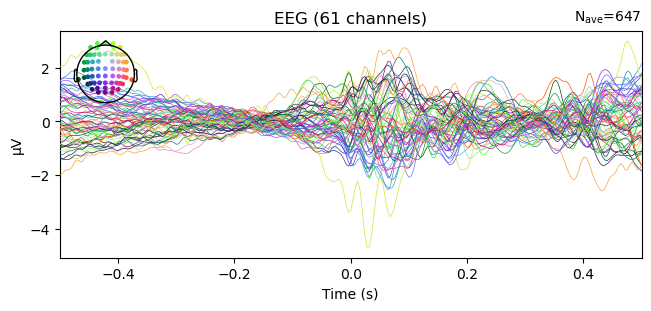

In [88]:
ECG_epochs.copy().average().plot()

In [70]:
ECG_events = mne.preprocessing.find_ecg_events(raw)
mne.annotations_from_events(ECG_events[0], raw.info['sfreq'])

Using channel ECG to identify heart beats.
Setting up band-pass filter from 5 - 35 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 5.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 4.75 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 35.25 Hz)
- Filter length: 2500 samples (10.000 s)

Number of ECG events detected : 823 (average pulse 78 / min.)


<Annotations | 823 segments: 999 (823)>

In [71]:
raw.plot()

Using qt as 2D backend.
Using pyopengl with version 3.1.6


Channels marked as bad:
none
Attempting to create new mne-python configuration file:
/Users/samuel/.mne/mne-python.json


In [17]:
metrics[str(raw.info['ch_names'][channel_nb])][metric].append(getattr(time_analysis, metric)(segment))

KeyError: 'Fp1'

In [30]:
raw.info['ch_names'][channel_nb].encode('utf-8').decode('utf-8')

'Fp1'

In [16]:
test = {'a': {'e':1}, 'b': 2}
l = ['a', 'b', 'e']
test[l[0]]

1

In [11]:
metrics['Fp1']

{'average_rms': [],
 'max_gradient': [],
 'zero_crossing_rate': [],
 'hjorth_mobility': [],
 'hjorth_complexity': [],
 'kurtosis': [],
 'skewness': [],
 'variance': [],
 'signal_range': [],
 'signal_IQR': []}

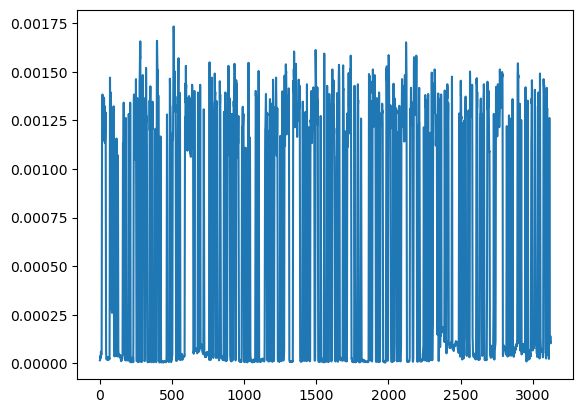

In [63]:
import matplotlib.pyplot as plt
plt.plot(metrics['Fp2']['signal_IQR'])

In [2]:
str(half_spectrum.dtype)

NameError: name 'half_spectrum' is not defined

In [1]:
from EEG_quality_assessment import frequency_analysis as spectrums_package

In [7]:
t = __import__('frequency_spectrums')

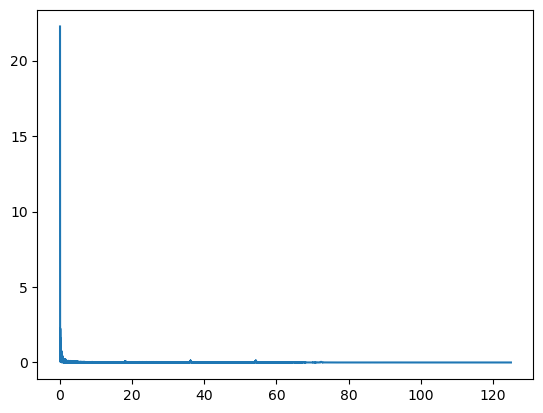

In [34]:
import matplotlib.pyplot as plt
plt.plot(frequencies,np.abs(half_spectrum[0,:]))

In [1]:
a = 'string'
type(a) == str

True